# Imports

In [1]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
import transformers
import tensorflow as tf
import tqdm.notebook as tqdm
import sklearn
import sklearn.model_selection
import matplotlib.pyplot as plt

from datasets import load_dataset
from sklearn.metrics import ConfusionMatrixDisplay

2023-11-12 20:19:47.303701: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-12 20:19:47.322640: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-12 20:19:47.322661: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-12 20:19:47.322671: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-12 20:19:47.327539: I tensorflow/core/platform/cpu_feature_g

In [2]:
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

cd /usr/lib/wsl/lib
# backup
sudo mv libcuda.so.1 libcuda.so.1.backup
sudo mv libcuda.so libcuda.so.backup
# create symlink manually
sudo ln -s libcuda.so.1.1 libcuda.so.1
sudo ln -s libcuda.so.1 libcuda.so
# update cache
sudo ldconfig

In [3]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except:
        pass

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-11-12 20:19:48.708687: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-12 20:19:48.709413: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-12 20:19:48.709431: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


# Data

Load and prepare your dataset. Dataset should have at least 10k samples in it. Each dataset cannot be used by more than two students.

In [4]:
dataset = load_dataset('ItsNotRohit/Food121-224', split='test')

In [5]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 24200
})

# Backbone

Load pretrained model from Hugging Face (or some other model repository if it's more convenient). Model should be trained on Feature Extraction task.

In [6]:
backbone = transformers.AutoModel.from_pretrained('facebook/dinov2-base').cuda()

Load tokenizer to be used with the model

In [7]:
processor = transformers.AutoImageProcessor.from_pretrained('facebook/dinov2-base')

# Feature extraction

Since we will not be training the backbone, extract features from your dataset.

Run the backbone on the images and save the extracted features. Don't forget to process the images. Images don't have to be of the same size, though it would be faster if they were. If the images don't fit in memory, lazily load them from disk

In [ ]:
features = []

with torch.no_grad():
    for image in tqdm.tqdm(dataset['image']):
        image = processor(np.array(image), return_tensors='pt')['pixel_values'].cuda()
        features.extend(backbone(image).pooler_output.cpu().numpy())

features = np.array(features)

In [9]:
features.shape

(24200, 768)

# Prepare train/test data

Split your data (extracted features and labels) into train and test subsets.

In [10]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(features, np.array(dataset['label']) )

Prepare `tf.data.Dataset` or some other way for the data to be used during training.

In [11]:
train_X = tf.data.Dataset.from_tensor_slices(X_train)
train_y = tf.data.Dataset.from_tensor_slices(y_train)
train_dataset = tf.data.Dataset.zip((train_X, train_y)).batch(128)

test_X = tf.data.Dataset.from_tensor_slices(X_test)
test_y = tf.data.Dataset.from_tensor_slices(y_test)
test_dataset = tf.data.Dataset.zip((test_X, test_y)).batch(128)

2023-11-12 19:02:38.771341: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-12 19:02:38.771434: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-12 19:02:38.771445: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-12 19:02:38.772064: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-12 19:02:38.772128: I tensorflow/compile

# Build the model

Build a simple model. The model should accept an extracted feature vector and return a vector of class logits (or probabilities). Model should only have a couple (or even 1) layers with weights.

In [12]:
inputs = tf.keras.layers.Input(768, name='input', dtype=tf.float32)
x = tf.keras.layers.Dense(256, name='Dense2')(inputs)
x = tf.keras.layers.Dense(np.unique(dataset['label']).size, name='Predict')(x)
model = tf.keras.Model(inputs=inputs, outputs=x, name='MyModel')

2023-11-12 20:24:49.970542: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-12 20:24:49.970585: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-12 20:24:49.970596: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-12 20:24:49.970757: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-12 20:24:49.970770: I tensorflow/compile

In [13]:
model.summary()

Model: "MyModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 768)]             0         
                                                                 
 Dense2 (Dense)              (None, 256)               196864    
                                                                 
 Predict (Dense)             (None, 121)               31097     
                                                                 
Total params: 227961 (890.47 KB)
Trainable params: 227961 (890.47 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 768)]             0         
                                                                 
 Dense2 (Dense)    

Compile the model. Choose loss and metrics.

In [14]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics='accuracy')

# Train the model

In [15]:
model.fit(train_dataset, validation_data=test_dataset, epochs=10)

NameError: name 'train_dataset' is not defined

# Evaluation

Evalute the model on test data.

In [16]:
model.evaluate(X_test, y_test, batch_size=128)

48/48 [==============================] - 0s 2ms/step - loss: 0.9078 - accuracy: 0.8362


[0.9077962040901184, 0.8361983299255371]

Plot confusion matrix.

190/190 [==============================] - 0s 1ms/step


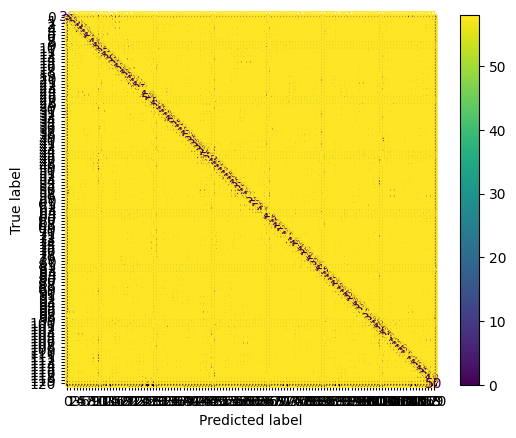

In [17]:
ConfusionMatrixDisplay.from_predictions(y_test, model.predict(X_test).argmax(axis=-1))

Perform dimensiality reduction and plot the extracted features. Do classes form clusters?

In [18]:
def scale(data):
    return np.array([
        (i - data.min()) / (data.max() - data.min())
        for i in data
    ])

In [43]:
import sklearn.decomposition
import sklearn.manifold

def plot_thing(data: pd.DataFrame, processor, backbone, n_classes: int, n_images_per_class: int, threshold: float = 1, batch_size: int = 8, image_size: int = 640, use_tsne: bool = True):
    rng = np.random.default_rng()

    old_image_size = processor.size['shortest_edge']
    processor.crop_size['height'] = processor.crop_size['width'] = image_size
    processor.size['shortest_edge'] = image_size

    classes = rng.choice(np.unique(data['label']), replace=False, size=n_classes)
    images = []
    for i in classes:
        for j in rng.choice(data['image'][data['label'] == i], size=n_images_per_class, replace=False):
            images.append(cv2.cvtColor(np.array(j), cv2.COLOR_RGBA2RGB))

    img = processor(images, return_tensors='pt')
    img = img['pixel_values'].cuda()

    with torch.no_grad():
        n_batches = (img.shape[0] + batch_size - 1) // batch_size
        features = np.concatenate([backbone(img[i * batch_size:(i + 1) * batch_size]).last_hidden_state.cpu().numpy()[:, 1:] for i in tqdm.trange(n_batches)], axis=0)

    del img

    n = int(np.sqrt(features.shape[1]))

    if use_tsne:
        features = scale(sklearn.manifold.TSNE(n_components=3).fit_transform(features.reshape(-1, features.shape[-1])).reshape(-1, n, n, 3))
    else:
        features = scale(sklearn.decomposition.PCA(n_components=3).fit_transform(features.reshape(-1, features.shape[-1])).reshape(-1, n, n, 3))

    processor.do_rescale = False
    processor.do_normalize = False
    images = processor(images=images, return_tensors='np')['pixel_values'].transpose(0, 2, 3, 1)
    processor.do_rescale = True
    processor.do_normalize = True

    processor.crop_size['height'] = processor.crop_size['width'] = old_image_size
    processor.size['shortest_edge'] = old_image_size

    _, ax = plt.subplots(ncols=n_classes * 2, nrows=n_images_per_class, figsize=(10 * n_classes, 5 * n_images_per_class))
    
    mask = features[..., 0] <= threshold
    features = np.where(mask[..., None], features, 0.)

    features = features.reshape(n_classes, n_images_per_class, n, n, 3)
    images = images.reshape(n_classes, n_images_per_class, *images.shape[1:3], 3)

    for i in range(n_classes):
        for j in range(n_images_per_class):
            ax[j, 2 * i].imshow(images[i, j])
            ax[j, 2 * i].axis('off')
            
            ax[j, 2 * i + 1].imshow(features[i, j])
            ax[j, 2 * i + 1].axis('off')

        ax[0, 2 * i].set_title(classes[i])

    plt.tight_layout()

In [20]:
df = pd.DataFrame(dataset)

  0%|          | 0/2 [00:00<?, ?it/s]

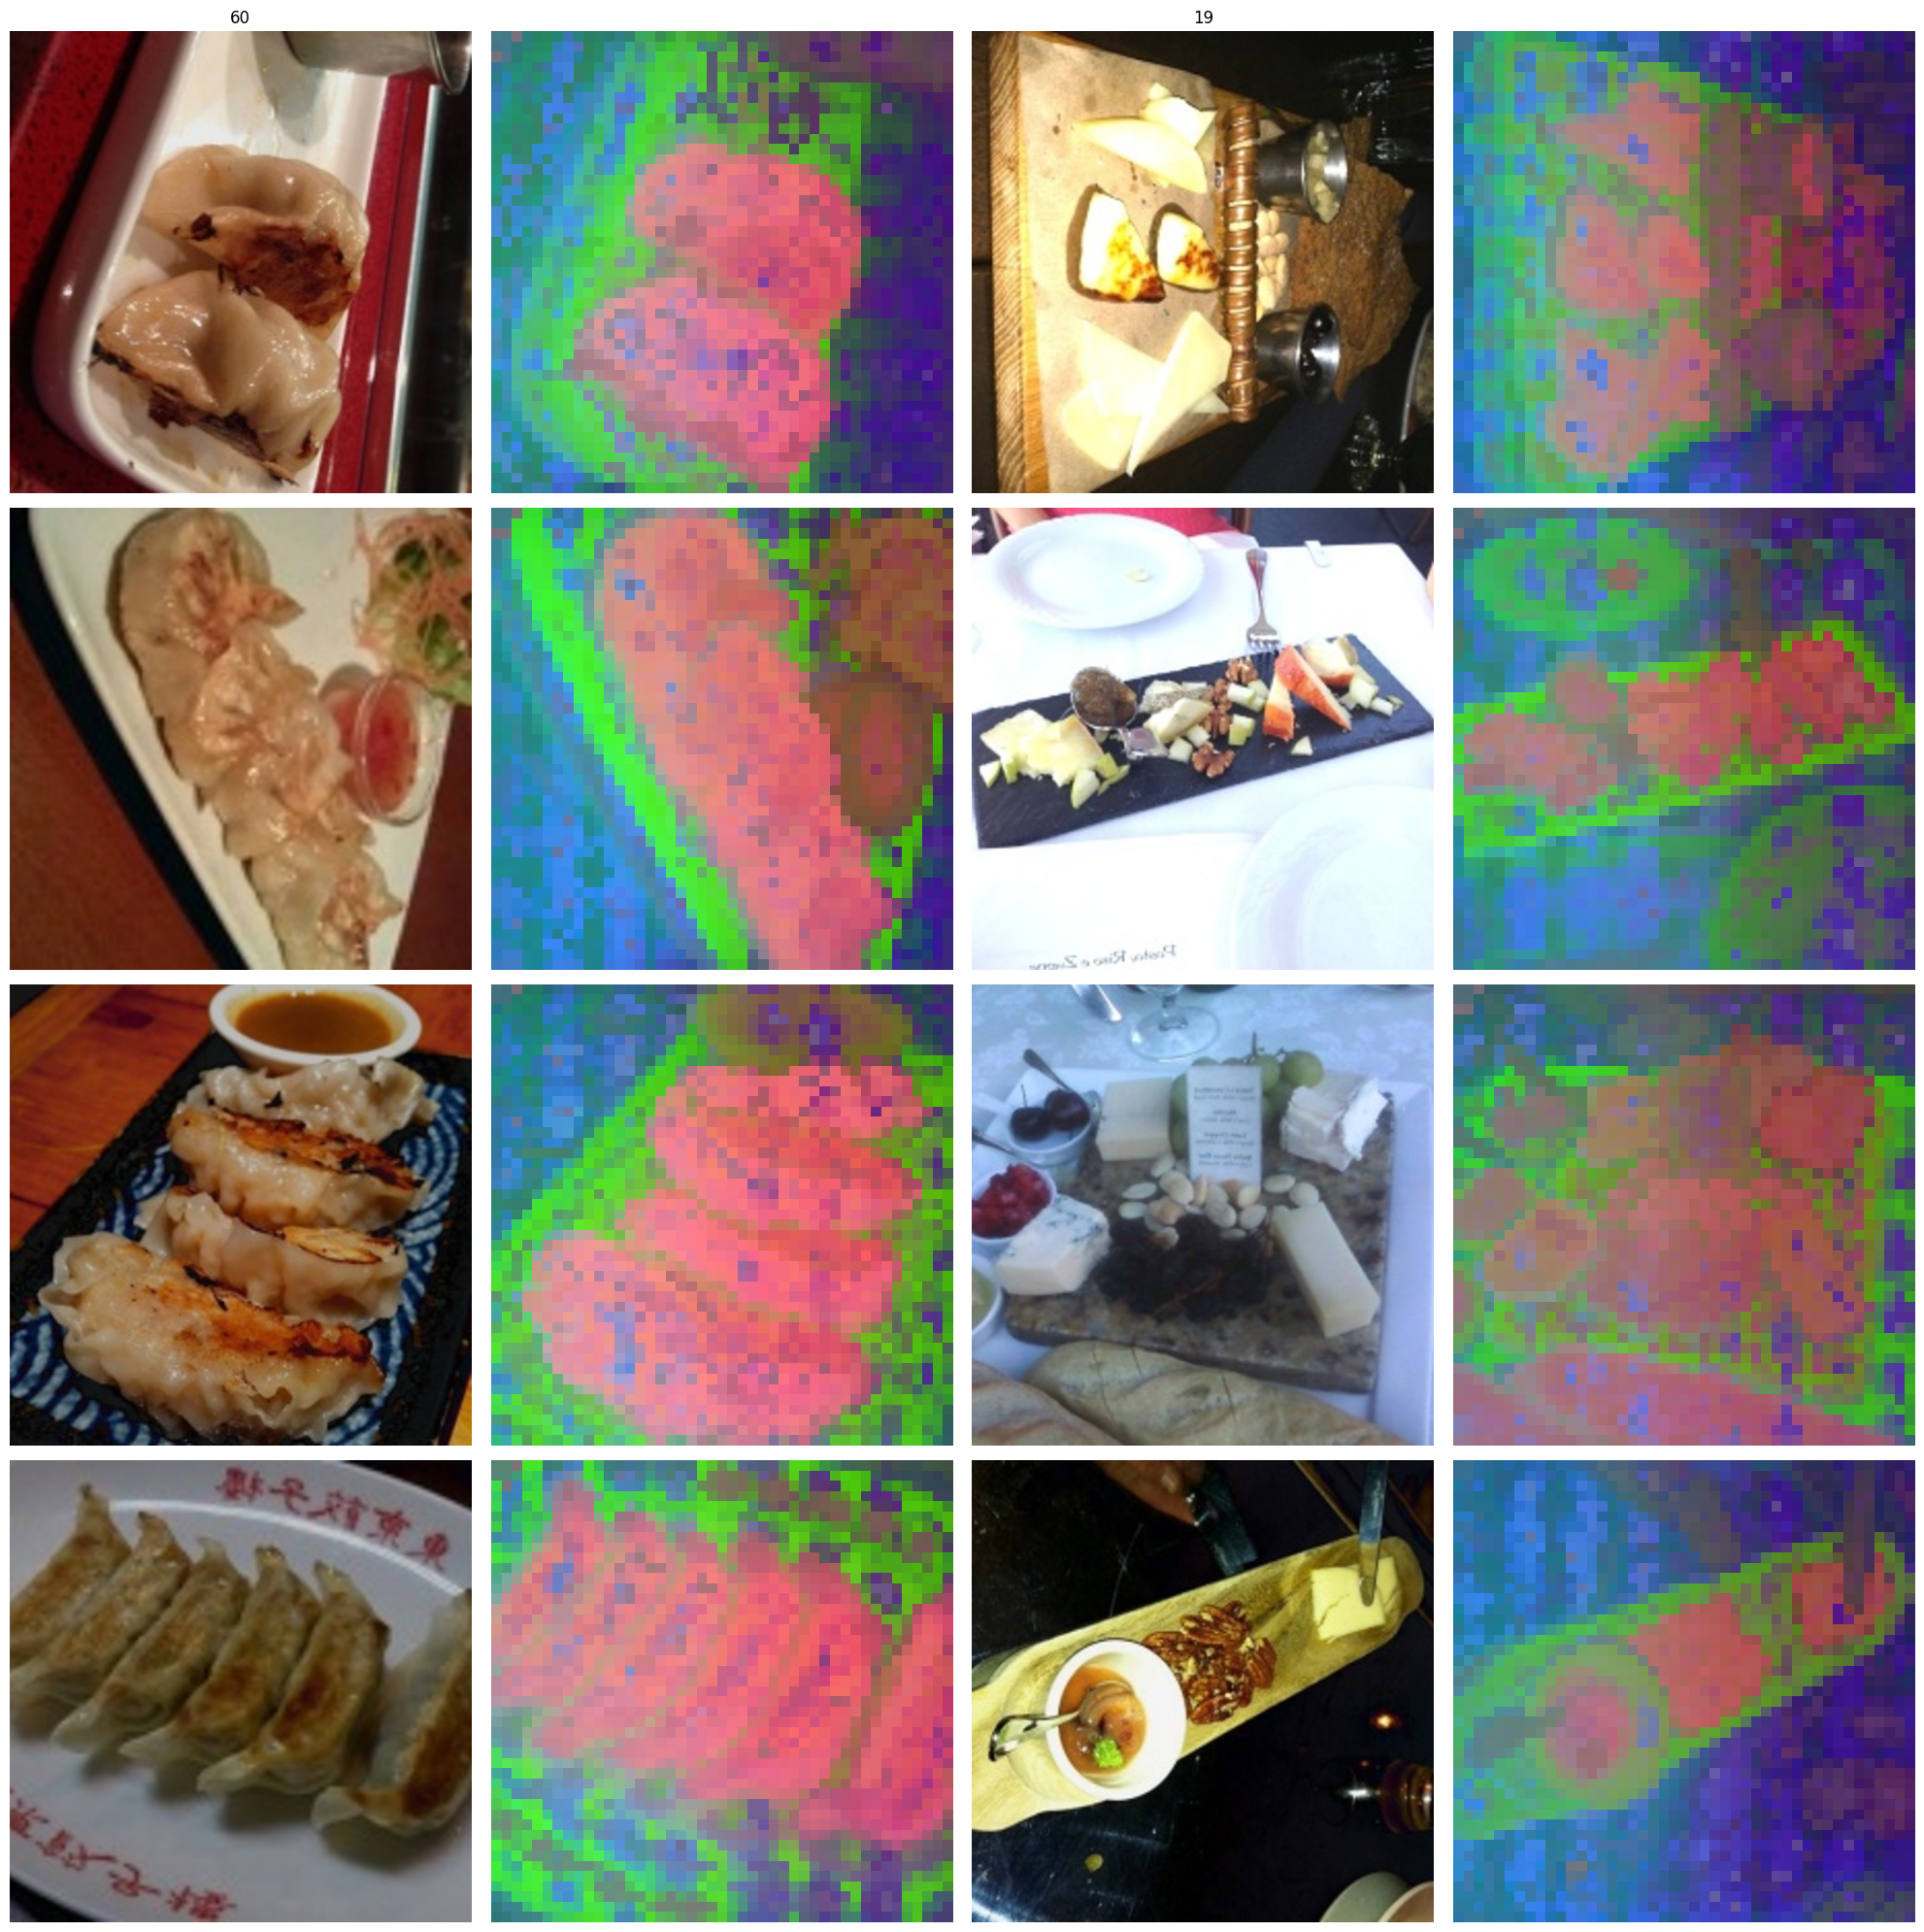

In [46]:
plot_thing(df, processor, backbone, 2, 4, threshold=1, batch_size=4, image_size=640, use_tsne=False)

In [28]:
with open('class_names.txt', 'r') as class_names:
    class_names = class_names.read().split('\n')

In [49]:
from PIL import Image

def classify_image(image_path: str) -> str:
    image = Image.open(image_path)
    image.load()
    
    with torch.no_grad():
        image = processor(np.array(image), return_tensors='pt')['pixel_values'].cuda()
        feature = backbone(image).pooler_output.cpu().numpy()

    pred = model.predict(feature)
    
    return class_names[pred.argmax(axis=-1)[0]]

In [51]:
classify_image('dump.jpg')

1/1 [==============================] - 0s 11ms/step


'kathi_rolls'

# Bonus

Check if the feature extractor model can be used without a classifier layer (how large is the average feature vector similarity inbetween same in different classes)